# Vehicle Detection Project

The goals / steps of this project are the following:

    1. Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
    2. Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector.
    Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
    3. Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
    4. Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
    5. Estimate a bounding box for vehicles detected.


In [174]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from lesson_function import *
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label

## 1. HOG feature extraction/ train a SVC classifier

#### 1) Explore the car and nocar images

In [26]:
# Read in car and non-car images
cars = glob.glob('./data/vehicles/**/*.png', recursive=True)
nocars = glob.glob('./data/non-vehicles/**/*.png', recursive=True)

print('len(cars)', len(cars))
print('len(notcars)', len(notcars))
    
print(cars[0:4])

len(cars) 8792
len(notcars) 8968
['./data/vehicles/KITTI_extracted/2700.png', './data/vehicles/KITTI_extracted/650.png', './data/vehicles/KITTI_extracted/5467.png', './data/vehicles/KITTI_extracted/2421.png']


In [34]:
rnd_idx=np.random.randint(len(cars))

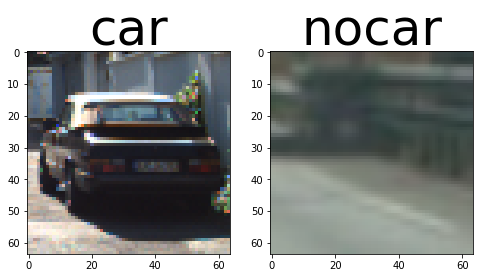

In [35]:
plt.figure(figsize=(8,6))
plt.subplot(1,2,1)
carsample=plt.imread(cars[rnd_idx])
plt.imshow(carsample)
plt.title('car',fontsize=50)
plt.subplot(1,2,2)
nocarsample=plt.imread(nocars[rnd_idx])
plt.imshow(nocarsample)
plt.title('nocar',fontsize=50)

#### 2) explored different color spaces

In [85]:
#Test with HOG
def get_hog_features(image, cspace='RGB', orient=8, pix_per_cell=(8,8), 
                     cell_per_block=(2,2), hog_channel=0, vis=False, feat_vec=True):
    if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    else: 
        feature_image = np.copy(image)
    
    if hog_channel<3:
        img = feature_image[:,:,hog_channel]
    else:
        img = np.copy(feature_image)
    
    #print('feature_image.shape', feature_image.shape)  
    #print('img.shape',img.shape)  
    
    
    if vis == True:
        # Use skimage.hog() to get both features and a visualization
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=pix_per_cell, cells_per_block=cell_per_block, visualise=vis, transform_sqrt=False, feature_vector=feat_vec, normalise=None)
        return features, hog_image
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=pix_per_cell, cells_per_block=cell_per_block, visualise=vis, transform_sqrt=False, feature_vector=feat_vec, normalise=None)
        return features
    


In [129]:
def get_hog_interact(image, color_space, orient =8, npixpercells =8, 
                     cellsperblock = 1,hog_channel=0, vis=True, feat_vec=True):
    # apply color conversion if other than 'RGB'
    if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(image)
        
    if hog_channel == 'ALL':
        hog_features = []
        hog_images = []
        for channel in range(feature_image.shape[2]):
            features, hog_image = get_hog_features(feature_image, color_space, orient, 
                                                   (npixpercells,npixpercells), 
                                                   (cellsperblock,cellsperblock), 
                                                   channel, vis, feat_vec)
            plt.figure(figsize=(10,6))
            plt.subplot(121)
            plt.imshow(feature_image[:,:,channel],cmap='gray')
            plt.title('Channel: %d' %channel,fontsize=30)
            plt.subplot(122)
            plt.imshow(hog_image, cmap = 'gray')
            plt.title('HOG: %d' %channel,fontsize=30)
            
            
    

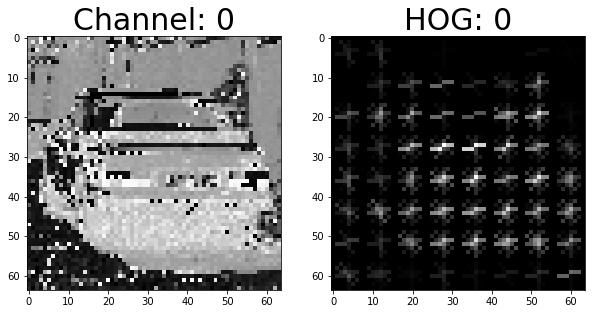

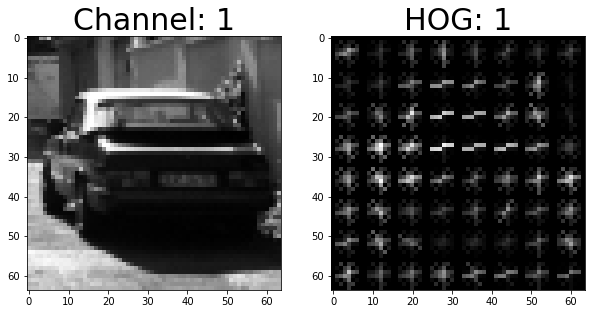

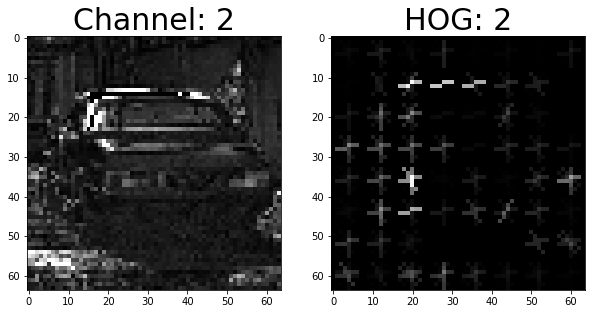

In [130]:
feature_image=get_hog_interact(carsample, 'HLS', 9, 8,2,'ALL', True, False)

#### 2) Explain how you settled on your final choice of HOG parameters
#### 3) Describe how (and identify where in your code) you trained a classifier using your selected HOG features 

In [132]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, cspace='RGB', orient=8, 
                        pix_per_cell=8, cell_per_block=4, hog_channel=0):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append the new feature vector to the features list
        features.append(hog_features)
        
    # Return list of feature vectors
    return features



In [135]:
### TODO: Tweak these parameters and see how the results change.
colorspace = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 8
pix_per_cell = 8
cell_per_block = 1
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"

t=time.time()
car_features = extract_features(cars, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
notcar_features = extract_features(nocars, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)     
print('X.shape',X.shape)
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')

58.33 Seconds to extract HOG features...
X.shape (17760, 1536)
Using: 8 orientations 8 pixels per cell and 1 cells per block
Feature vector length: 1536
2.91 Seconds to train SVC...


In [137]:
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 15
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

Test Accuracy of SVC =  0.9775
6e-05 Seconds to predict 15 labels with SVC


In [139]:
#save the scalar and clf
import pickle
pickle.dump( svc, open( "saved_svc.p", "wb" ) )
pickle.dump( X_scaler, open( "saved_X_scaler.p", "wb" ) )

## 3.Sliding Window Search

In [140]:
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

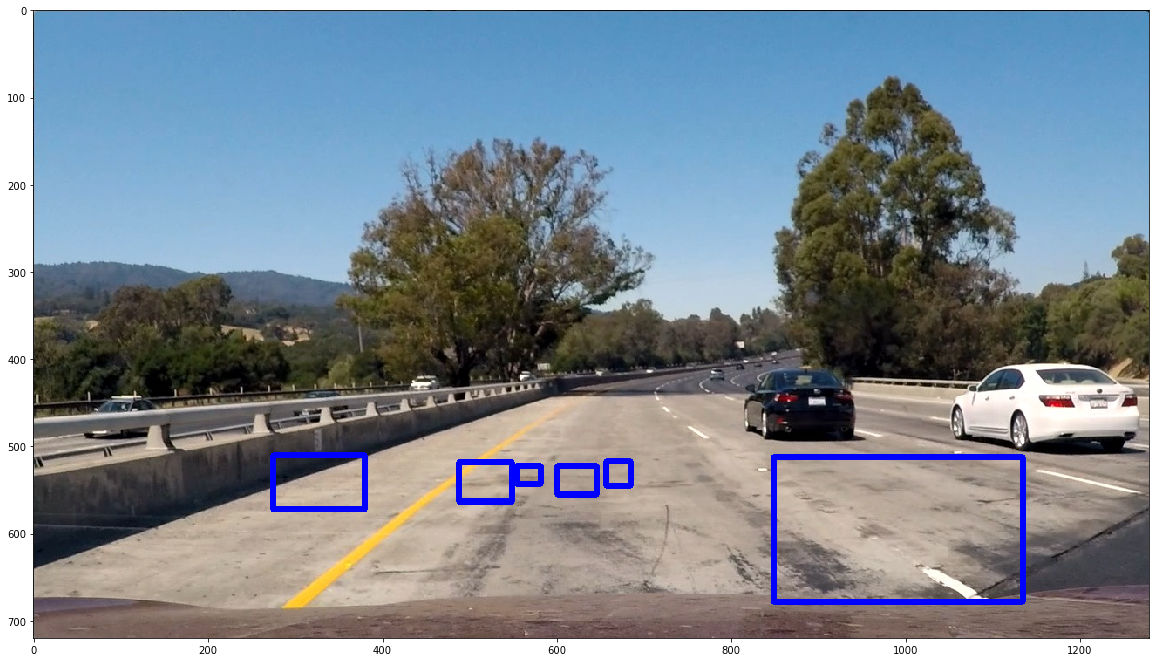

In [141]:
image = mpimg.imread('test_images/test1.jpg')

#Box drawing
# Define a function that takes an image, a list of bounding boxes, 
# and optional color tuple and line thickness as inputs
# then draws boxes in that color on the output

def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # make a copy of the image
    draw_img = np.copy(img)
    # draw each bounding box on your image copy using cv2.rectangle()
    for b in bboxes:
        cv2.rectangle(draw_img, b[0],b[1], color, thick)
    # return the image copy with boxes drawn
    return draw_img # Change this line to return image copy with boxes
# Add bounding boxes in this format, these are just example coordinates.
bboxes = [((275, 572), (380, 510)), ((488, 563), (549, 518)), ((554, 543), (582, 522)), 
          ((601, 555), (646, 522)), ((657, 545), (685, 517)), ((849, 678), (1135, 512))]


result = draw_boxes(image, bboxes)

plt.figure(figsize=(20,20))
plt.imshow(result)

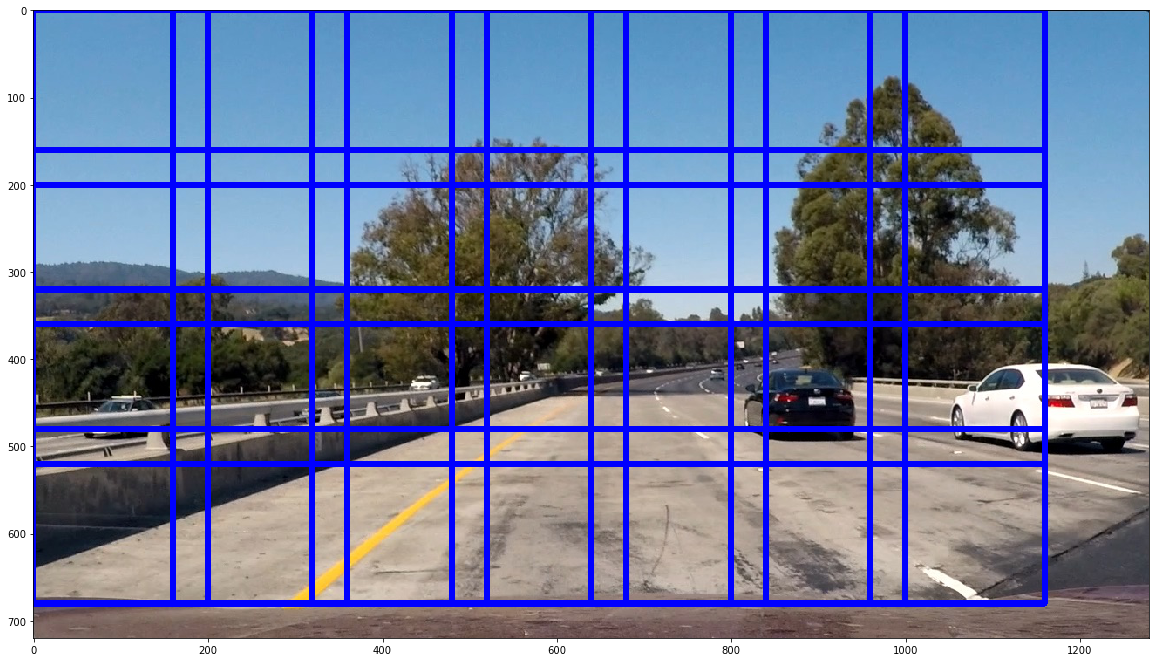

In [142]:
w_list = slide_window(image, x_start_stop=[0, 1280], y_start_stop=[0, 720], xy_window=(200,200), xy_overlap=(0.2, 0.2))
result = draw_boxes(image, w_list)

plt.figure(figsize=(20,20))
plt.imshow(result)

(720, 1280, 3)
(256, 1280, 3)


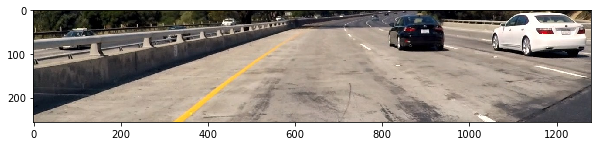

In [144]:
img = mpimg.imread('./test_images/test1.jpg')
#draw_img = np.copy(img)
#img = img.astype(np.float32)/255

ystart = 400
ystop = 656
img_tosearch = img[400:656,:,:]
print(img.shape)
print(img_tosearch.shape)

plt.figure(figsize=(10,10))
plt.imshow(img_tosearch)
#img2 = convert_color(img, conv='RGB2YCrCb')
#print(img2.shape)



In [145]:
#HOG SUBSAMPLE
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pickle
import cv2
from sklearn.preprocessing import StandardScaler

#svc = pickle.load( open("saved_svc.p", "rb" ) )
#X_scaler =pickle.load( open( "saved_X_scaler.p", "rb" ) )


# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc,  orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, cspace, X_scaler,showImage =True):
    count =0
    draw_img = np.copy(img)
    #img = img.astype(np.float32)/255
    boxes =[]
    
    img_tosearch = img[ystart:ystop,:,:]
    #print(ystart,ystop)
    #print('img', img.shape)
    #print('img_tosearch', img_tosearch.shape)
    
    #ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if cspace != 'RGB':
        if cspace == 'HSV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
    else: ctrans_tosearch = np.copy(img_tosearch)  
                    
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)-1
    nyblocks = (ch1.shape[0] // pix_per_cell)-1 
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    #nblocks_per_window = (window // pix_per_cell)-1 
    nblocks_per_window = (window // pix_per_cell)
    
    cells_per_step = 1  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            
            #print(yb ,' ypos ',ypos)
            #print(yb ,' ypos ',ypos+nblocks_per_window)
                            
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].reshape(1, -1)   
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].reshape(1, -1)   
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].reshape(1, -1)   
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            #subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))

            # Get color features
            #spatial_features = bin_spatial(subimg, size=spatial_size)
            #hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            #test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #print('hog_features.shape',hog_features.shape)

            #X_scaler = StandardScaler().fit(hog_features)
            test_features = X_scaler.transform(hog_features).reshape(1, -1)   

            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)

            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                c1 =  np.random.randint(0, 255)
                c2 =  np.random.randint(0, 255)
                c3 =  np.random.randint(0, 255)
                count+=1
                if showImage==True:
                    cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(c1,c2,c3),6)              
                    cv2.putText(draw_img,str( count), (int(xbox_left),int(ytop_draw+ystart)), cv2.FONT_HERSHEY_SIMPLEX, 2,(255,255,255), 2,  lineType = cv2.LINE_AA)
                else:
                    if count>0:
                        boxes.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))

    if showImage:
        return draw_img, count
    else:
        return boxes, count
 

In [166]:
#HOG SUBSAMPLE BOX ONLY
# Study of boxes positions
def find_cars_boxOnly(img, ystart, ystop, scale, svc,  orient,
                      pix_per_cell, cell_per_block, spatial_size, hist_bins,
                      cspace, X_scaler,showImage =True):
    count=0
    draw_img = np.copy(img)
    #img = img.astype(np.float32)/255
    boxes =[]
    
    img_tosearch = img[ystart:ystop,:,:]
    #print(ystart,ystop)
    #print('img', img.shape)
    #print('img_tosearch', img_tosearch.shape)
    
    #ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    ctrans_tosearch = np.copy(img_tosearch)  
                    
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)-1
    nyblocks = (ch1.shape[0] // pix_per_cell)-1 
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    #nblocks_per_window = (window // pix_per_cell)-1 
    nblocks_per_window = (window // pix_per_cell)
    
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step

    '''
    #Plot only the diagonal
    for xb in range(nxsteps):
        yb = xb 
        ypos = yb*cells_per_step
        xpos = xb*cells_per_step

        xleft = xpos*pix_per_cell
        ytop = ypos*pix_per_cell

        xbox_left = np.int(xleft*scale)
        ytop_draw = np.int(ytop*scale)
        win_draw = np.int(window*scale)
        c1 =  np.random.randint(0, 255)
        c2 =  np.random.randint(0, 255)
        c3 =  np.random.randint(0, 255)
        count+=1

        cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),
                      (xbox_left+win_draw,ytop_draw+win_draw+ystart), (c1,c2,c3),
                      6)              
        cv2.putText(draw_img,str( count), (int(xbox_left),int(ytop_draw+ystart)), cv2.FONT_HERSHEY_SIMPLEX,1,(255,255,255), 2,  lineType = cv2.LINE_AA)

    '''  
    #Plot one value to the right
    xb = nxsteps
    yb= 0
    ypos = yb*cells_per_step
    xpos = xb*cells_per_step

    xleft = xpos*pix_per_cell
    ytop = ypos*pix_per_cell

    xbox_left = np.int(xleft*scale)
    ytop_draw = np.int(ytop*scale)
    win_draw = np.int(window*scale)
    c1 =   0
    c2 =   0
    c3 =  255
    count+=1

    cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),
                  (xbox_left+win_draw,ytop_draw+win_draw+ystart),(c1,c2,c3),6)              
    #cv2.putText(draw_img,str( count), (int(xbox_left),int(ytop_draw+ystart)), cv2.FONT_HERSHEY_SIMPLEX,1,(255,255,255), 2,  lineType = cv2.LINE_AA)
     

    return draw_img, count
 

1


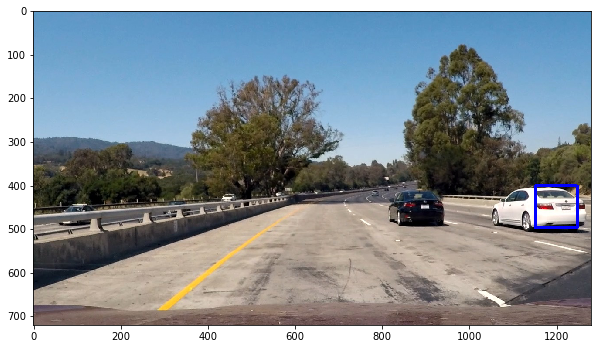

In [167]:
#Test find_cars_boxOnly
ystart = 400
ystop = 600
scale = 1.5


orient = 8 #dist_pickle["orient"]
pix_per_cell = 8 #dist_pickle["pix_per_cell"]
cell_per_block = 1 # dist_pickle["cell_per_block"]
spatial_size = (32, 32) #dist_pickle["spatial_size"]
hist_bins = 32 # dist_pickle["hist_bins"]
cspace = 'YCrCb'
show = True
draw_img, count = find_cars_boxOnly(img, ystart, ystop, scale, svc, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, cspace, X_scaler,True)


print(count)
plt.figure(figsize=(10,10))
plt.imshow(draw_img)

In [169]:
#Run find_cars in several scales
def find_cars_multiple(img, ystart, ystop, svc, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, cspace, X_scaler):
    
    scales = [1.1,1.4, 1.8, 2.4, 2.9, 3.4]
    
    c=0
    bbox = []           
    for scale in scales:
        c+=1
        #The first half of scales is valid for the upper half of image
        if c<len(scales):
            ystartaux = ystart
            ystopaux = int((ystart+ystop)/2)
        else:
            ystartaux = int((ystart+ystop)/2)
            ystopaux = ystop

        box, count = find_cars(img, ystartaux, ystopaux, scale, svc, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, cspace, X_scaler,False)
        if count>0:
            for b in box:
                bbox.append(b)
    return bbox

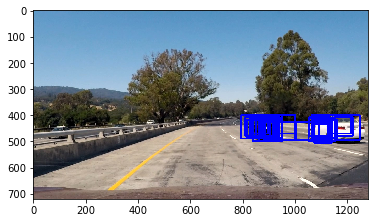

In [173]:
ystart = 400
ystop = 656

orient = 8 #dist_pickle["orient"]
pix_per_cell = 8 #dist_pickle["pix_per_cell"]
cell_per_block = 1 # dist_pickle["cell_per_block"]
spatial_size = (32, 32) #dist_pickle["spatial_size"]
hist_bins = 32 # dist_pickle["hist_bins"]
cspace = 'YCrCb'
show = True
bbox2 = find_cars_multiple(img, ystart, ystop, svc, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, cspace, X_scaler)

#print(bbox2)

for b in bbox2:
    cv2.rectangle(draw_img,b[0],
                  b[1],(0,0,255),6) 
plt.imshow(draw_img)

## 4. HEAT map to tackle flase positive

In [175]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
        

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(labels, heatmap,img=None):
    # Iterate through all detected cars
    b_heat=[] #((x1,y1),(x2,y2))

    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        highv = np.sum(heatmap[np.min(nonzeroy):np.max(nonzeroy), np.min(nonzerox):np.max(nonzerox)])
        
        
        # Draw the box on the image
        if not img is None:
            cv2.rectangle(img, bbox[0], bbox[1], (0,0,200), 3)
        
        b_heat.append(((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy))))

    # Return the image
    if not img is None:
        return img,b_heat
    else:
        return b_heat

In [176]:
def heatmap1(image,box_list,threshold=1, showImg = True):
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    # Add heat to each box in box list
    heat = add_heat(heat,box_list)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,threshold)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    
    
    if showImg ==  True:
        draw_img,lbl_heat = draw_labeled_bboxes( labels,heatmap,np.copy(image))
        return draw_img, heatmap,lbl_heat
    else:
        lbl_heat = draw_labeled_bboxes(labels,heatmap)
        return heatmap,lbl_heat

In [177]:
# Read in a pickle file with bboxes saved
# Each item in the "all_bboxes" list will contain a 
# list of boxes for one of the images shown above
box_list = bbox2.copy()

# Read in image similar to one shown above 
image = mpimg.imread('./test_images/test1.jpg')

[((809, 400), (1001, 499)), ((1052, 400), (1213, 499))]
[((809, 400), (1001, 499)), ((1052, 400), (1213, 499))]


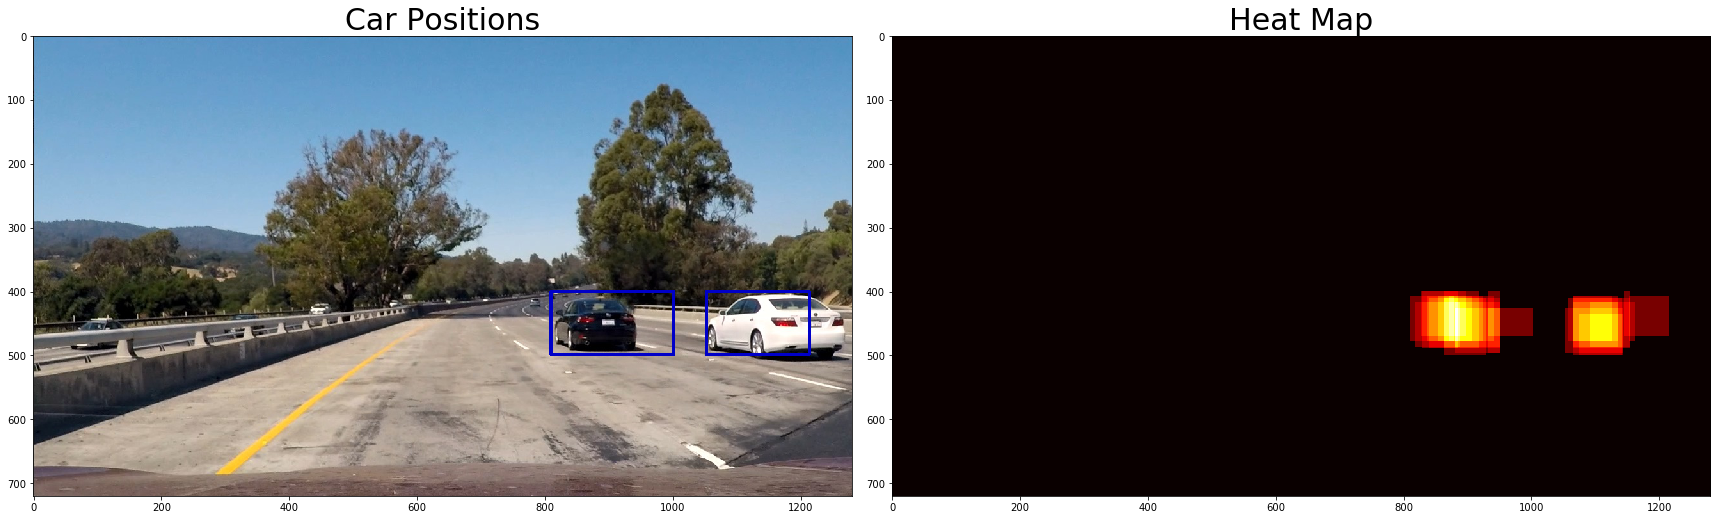

In [180]:
heata,lbl_ha = heatmap1(image,box_list,1,False)

print(lbl_ha)
dimg, heat,lbl_h = heatmap1(image,box_list,1,True)
print(lbl_h)
fig = plt.figure(figsize=(24,9))
plt.subplot(121)
plt.imshow(dimg)
plt.title('Car Positions',fontsize=30)
plt.subplot(122)
plt.imshow(heat, cmap='hot')
plt.title('Heat Map',fontsize=30)
fig.tight_layout()

#### extract image from the project video

In [209]:
clip1.write_images_sequence('./frames/frame%04d.png', fps=None, verbose=True, withmask=True)

[MoviePy] Writing frames ./frames/frame%04d.png.

386it [06:32,  1.03it/s]                     

KeyboardInterrupt: 

In [213]:
# test the heat map function
frame331=plt.imread('./frames/frame0331.png')

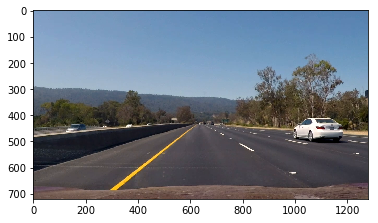

In [214]:
plt.imshow(frame331)

In [220]:
## combine all functions

In [218]:
nframes = 10
smooth_thres =8
smooth_average=6
bbox_frames =[]
#Inicialization of list
for i in range(nframes):
    bbox_frames.append(0)
counter = 0    

In [190]:
def process_image(img):
    global counter
    global bbox_frames
    
    counter+=1
    countFrame = counter % nframes
    
    #Find rectangles for one image
    bbox1 = find_cars_multiple(img, ystart, ystop, svc, orient, pix_per_cell, cell_per_block,
                               spatial_size, hist_bins, cspace, X_scaler)

    #Find heatmap single image
    thres = smooth_thres
    heat, bboxHeat = heatmap1(img,bbox1, thres, False)
    #print('bboxHeat',bboxHeat)

    #Store the rectangles of the frame
    bbox_frames[countFrame] = bboxHeat
    
    #Sum rectangles of the nframes
    bbox2=[]
    for box in bbox_frames:
        if box!=0:
            for b in box:
                bbox2.append(b)
    #print('bbox2',bbox2)
    
    #Find heatmap of average
    thres = smooth_average
    dimg, heat, bboxHeat2 = heatmap1(img,bbox2, thres, True)
    
    return dimg
    

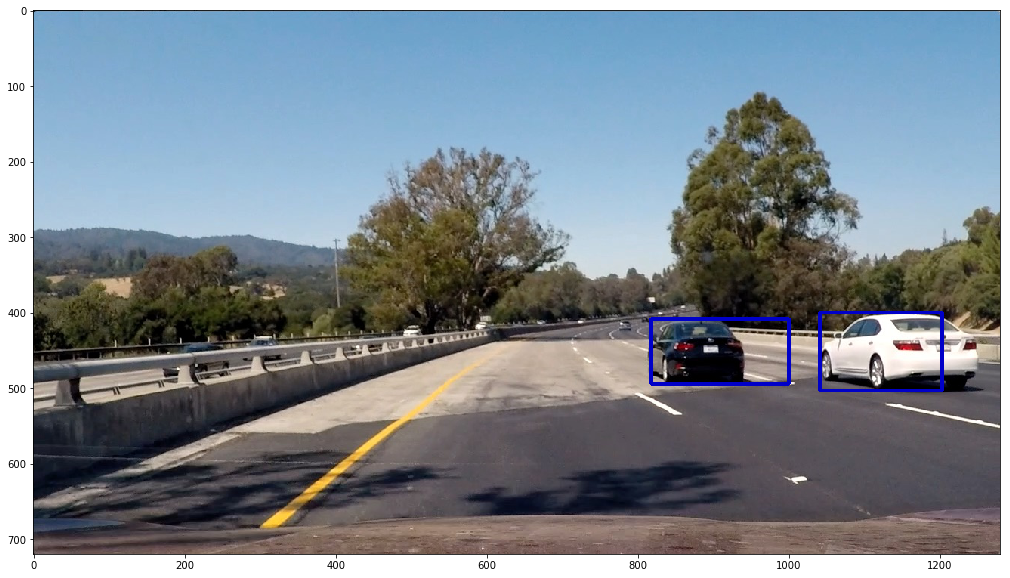

In [192]:
# Read in image similar to one shown above 
image = mpimg.imread('./test_images/test4.jpg')


plt.figure(figsize=(25,10))
nframes = 1
smooth_thres =0
smooth_average=0
bbox_frames=[]
#Inicialization of list
for i in range(nframes):
    bbox_frames.append(0)
counter = 0

img2 = process_image(image)
plt.imshow(img2)

## 5.video preparation

In [193]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import moviepy as mve

In [194]:
#Create video file pipeline
counter=0
nframes = 25
smooth_thres =1
smooth_average=6

bbox_frames=[]
#Inicialization of list
for i in range(nframes):
    bbox_frames.append(0)
counter = 0


output = 'output_video.mp4'

clip1 = VideoFileClip("project_video.mp4")

out_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time out_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video output_video.mp4
[MoviePy] Writing video output_video.mp4


100%|█████████▉| 1260/1261 [10:37<00:00,  1.94it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_video.mp4 

CPU times: user 1h 14min 9s, sys: 2min 2s, total: 1h 16min 11s
Wall time: 10min 38s
